# 0. Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.utils import to_categorical, normalize

# 1. Análisis Exploratorio de Datos

## 1.1. Descripción

El conjunto de datos MNIST nos permite llevar a cabo clasificación de imágenes. Este dataset contiene 30.000 dígitos escritos a mano. Las imágenes en blanco y negro de MNIST han sido suavizadas (anti-aliased), normalizadas y ajustadas a una caja de 28x28 pixeles, empleando 255 niveles en la escala de grises. El conjunto de datos ha sido preparado para usar las primeras 20.000 muestras en el entrenamiento y para usar el resto de las muestras con fines de testeo [1].

Todos estos dígitos en blanco y negro tienen un tamaño normalizado y están centrados en una imagen de tamaño fijo donde el centro de gravedad de la intensidad se encuentra en el centro de la imagen con 28 x 28 píxeles. Por lo tanto, la dimensionalidad de cada vector de muestra de imagen es 28 * 28 = 784, donde cada elemento es binario. Esta es una base de datos relativamente simple para las personas que desean probar técnicas de aprendizaje automático y métodos de reconocimiento de patrones en datos del mundo real mientras dedican un esfuerzo mínimo al preprocesamiento y formateo [2].

## 1.2. Visualización

Cargamos el dataset de entrenamiento MNIST desde Google Colab.

In [2]:
df = pd.read_csv("sample_data/mnist_train_small.csv", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Cargamos el dataset de testeo MNIST desde Google Colab.

In [3]:
df_test = pd.read_csv("sample_data/mnist_test.csv", header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Veamos la información de ambos datasets.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 119.8 MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 59.9 MB


Notamos que el dataset contiene las intensidades de cada uno de los pixeles en números enteros. Por otro lado, la primera columna corresponde a la clase a la que pertenece el número escrito. Veamos la distribución de muestras por cada clase en ambos datasets.

In [6]:
df.iloc[:, 0].value_counts()

1    2243
7    2126
6    2039
9    2023
3    2021
2    1989
0    1962
4    1924
8    1912
5    1761
Name: 0, dtype: int64

<Axes: >

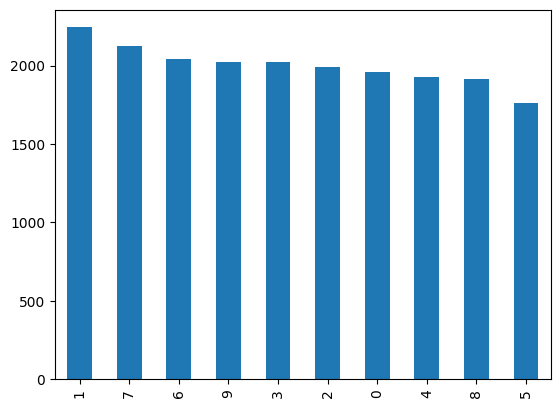

In [7]:
df.iloc[:, 0].value_counts().plot(kind="bar")

In [8]:
df_test.iloc[:, 0].value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: 0, dtype: int64

<Axes: >

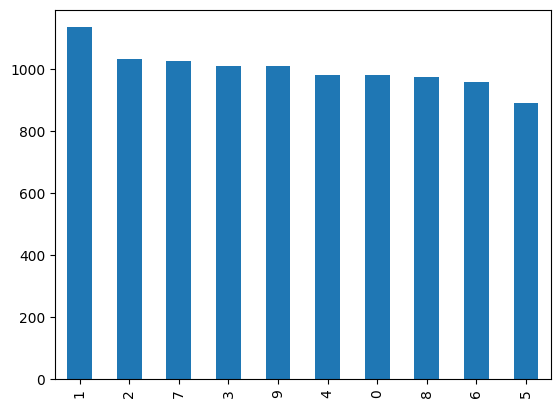

In [9]:
df_test.iloc[:, 0].value_counts().plot(kind="bar")

Según la distribución obtenida, se ve que hay un balance de datos bastante bien conseguido, sin embargo, hay cierta descompensación con el número 5.

## 1.3. Muestreo

Obtenemos una muestra aleatoria del dataset para visualizarlo.

In [10]:
rand = np.random.randint(0, 1999)
img_sample = df.iloc[rand, 1:].to_numpy().reshape(28, 28)
img_class = df.iloc[rand, 0]
img_sample.shape, img_class

((28, 28), 9)

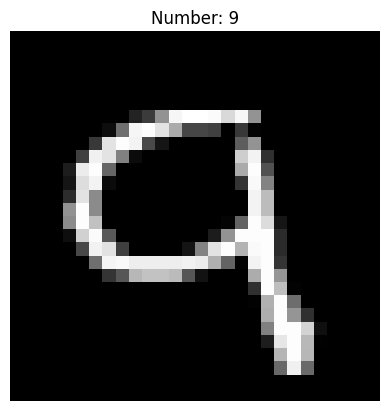

In [11]:
plt.figure()
plt.imshow(img_sample, cmap="gray")
plt.title(f"Number: {img_class}")
plt.axis("off")
plt.show()

Obtenemos un conjunto de muestras y las visualizamos en una misma figura.

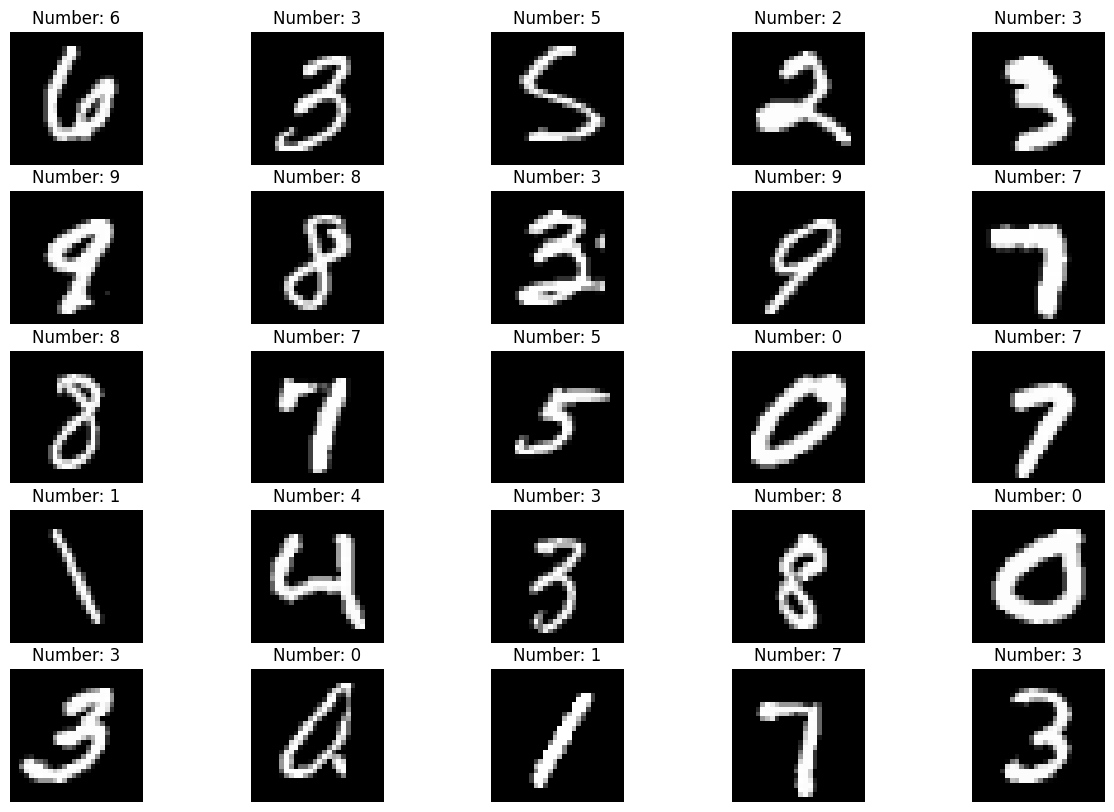

In [12]:
plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = np.random.choice(df.shape[0], 1)[0]
    plt.title(f"Number: {df.iloc[idx, 0]}")
    plt.imshow(df.iloc[idx, 1:].to_numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()

# 2. Comparación de modelos

Obtenemos el set de entrenamiento a partir del dataset de entrenamiento.

In [13]:
X_train = df.drop([0], axis=1)
y_train = df[[0]]
X_train.shape, y_train.shape

((20000, 784), (20000, 1))

Obtenemos el set de testeo a partir del dataset de testeo.

In [14]:
X_test = df_test.drop([0], axis=1)
y_test = df_test[[0]]
X_test.shape, y_test.shape

((10000, 784), (10000, 1))

Convertimos ambos sets en arrays de NumPy.

In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000, 784), (10000, 784), (20000,), (10000,))

Se entrenarán a distintos modelos y evaluaremos los resultados en la sección de Discusión.

## 2.1. Random Forest

In [16]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
preds = rf.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 95.92%
Macro-averaged Precision: 95.90%
Macro-averaged Recall: 95.88%
Macro-averaged F1 Score: 95.88%


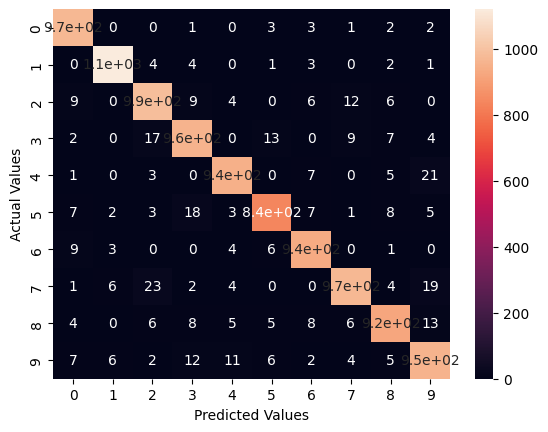

In [18]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.2. Support Vector Machine

In [19]:
svm = SVC(kernel="rbf", random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [20]:
preds = svm.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 97.00%
Macro-averaged Precision: 96.99%
Macro-averaged Recall: 96.97%
Macro-averaged F1 Score: 96.98%


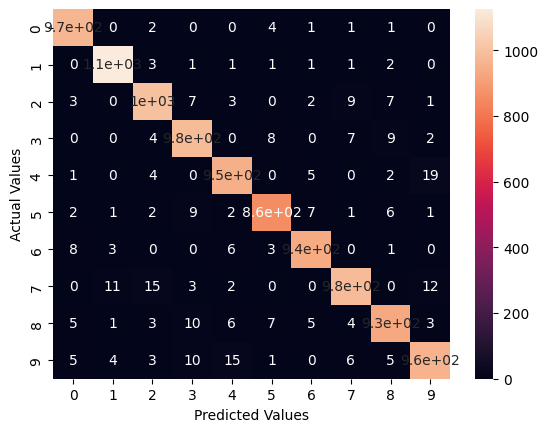

In [21]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.3. KNN

In [22]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [23]:
preds = knn.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 95.91%
Macro-averaged Precision: 96.00%
Macro-averaged Recall: 95.87%
Macro-averaged F1 Score: 95.91%


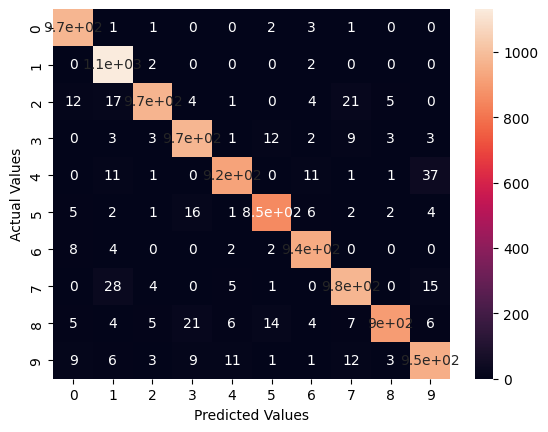

In [24]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.4. Logistic Regression

In [25]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [26]:
preds = lr.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 91.22%
Macro-averaged Precision: 91.09%
Macro-averaged Recall: 91.09%
Macro-averaged F1 Score: 91.08%


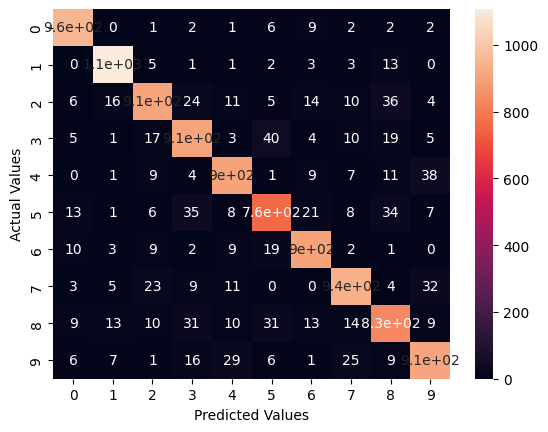

In [27]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.5. Decision Tree

In [28]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [29]:
preds = dt.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 84.26%
Macro-averaged Precision: 84.08%
Macro-averaged Recall: 84.08%
Macro-averaged F1 Score: 84.07%


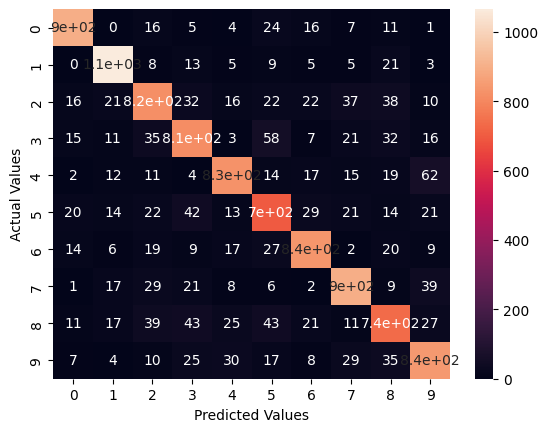

In [30]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.6. AdaBoost

In [31]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [32]:
preds = ada.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 75.49%
Macro-averaged Precision: 75.36%
Macro-averaged Recall: 75.22%
Macro-averaged F1 Score: 75.18%


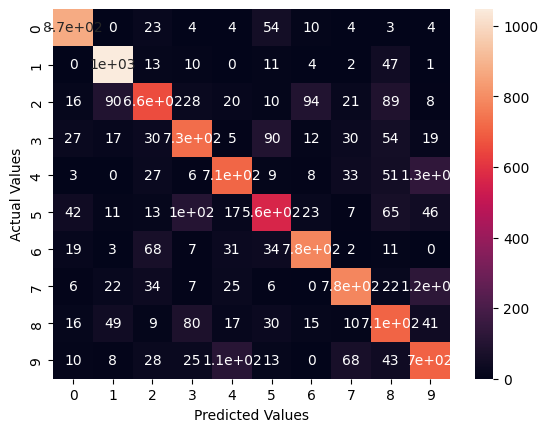

In [33]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.7. Bagging

In [34]:
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)

BaggingClassifier(random_state=42)

In [35]:
preds = bag.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 92.21%
Macro-averaged Precision: 92.15%
Macro-averaged Recall: 92.09%
Macro-averaged F1 Score: 92.10%


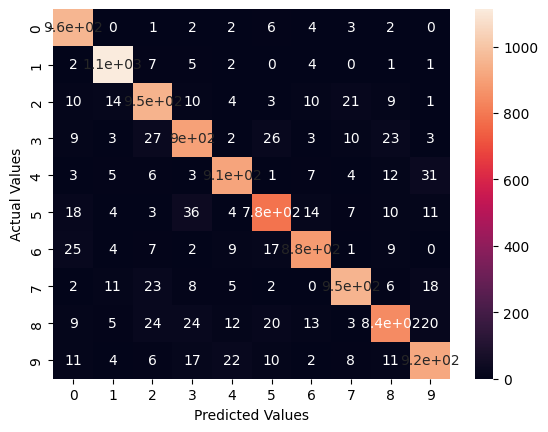

In [36]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.8. Gradient Boosting

In [37]:
gra = GradientBoostingClassifier(random_state=42)
gra.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [38]:
preds = gra.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 94.01%
Macro-averaged Precision: 93.95%
Macro-averaged Recall: 93.94%
Macro-averaged F1 Score: 93.94%


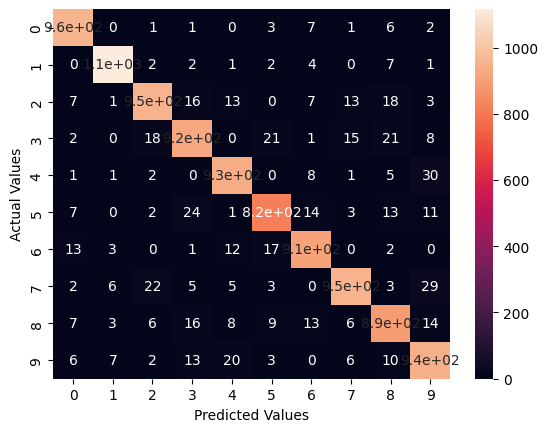

In [39]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.9. Histogram Gradient Boosting

In [40]:
his = HistGradientBoostingClassifier(random_state=42)
his.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [41]:
preds = his.predict(X_test)
acc = accuracy_score(y_test, preds)
pre_macro = precision_score(y_test, preds, average="macro")
pre_micro = precision_score(y_test, preds, average="micro")
recall_macro = recall_score(y_test, preds, average="macro")
recall_micro = recall_score(y_test, preds, average="micro")
f1_macro = f1_score(y_test, preds, average="macro")
f1_micro = f1_score(y_test, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

Accuracy: 96.85%
Macro-averaged Precision: 96.84%
Macro-averaged Recall: 96.83%
Macro-averaged F1 Score: 96.83%


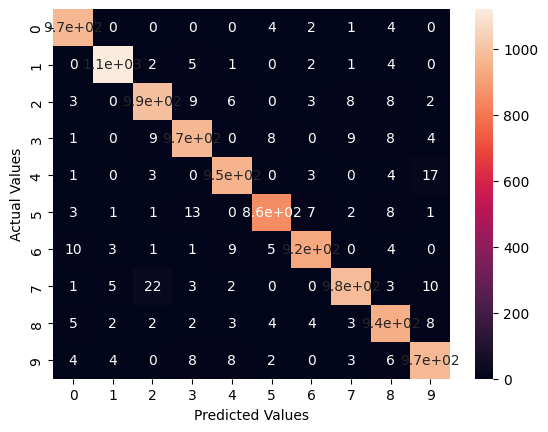

In [42]:
cm = confusion_matrix(y_test, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.10. Simple Perceptron

Convertimos las etiquetas a categorías para que sean compatibles con los perceptrones.

In [43]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [44]:
y_test_copy = np.copy(y_test)
X_train = normalize(X_train)
X_test = normalize(X_test)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [45]:
layer = tf.keras.layers.Dense(units=10, input_shape=[784])
model = tf.keras.Sequential([layer])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=False)


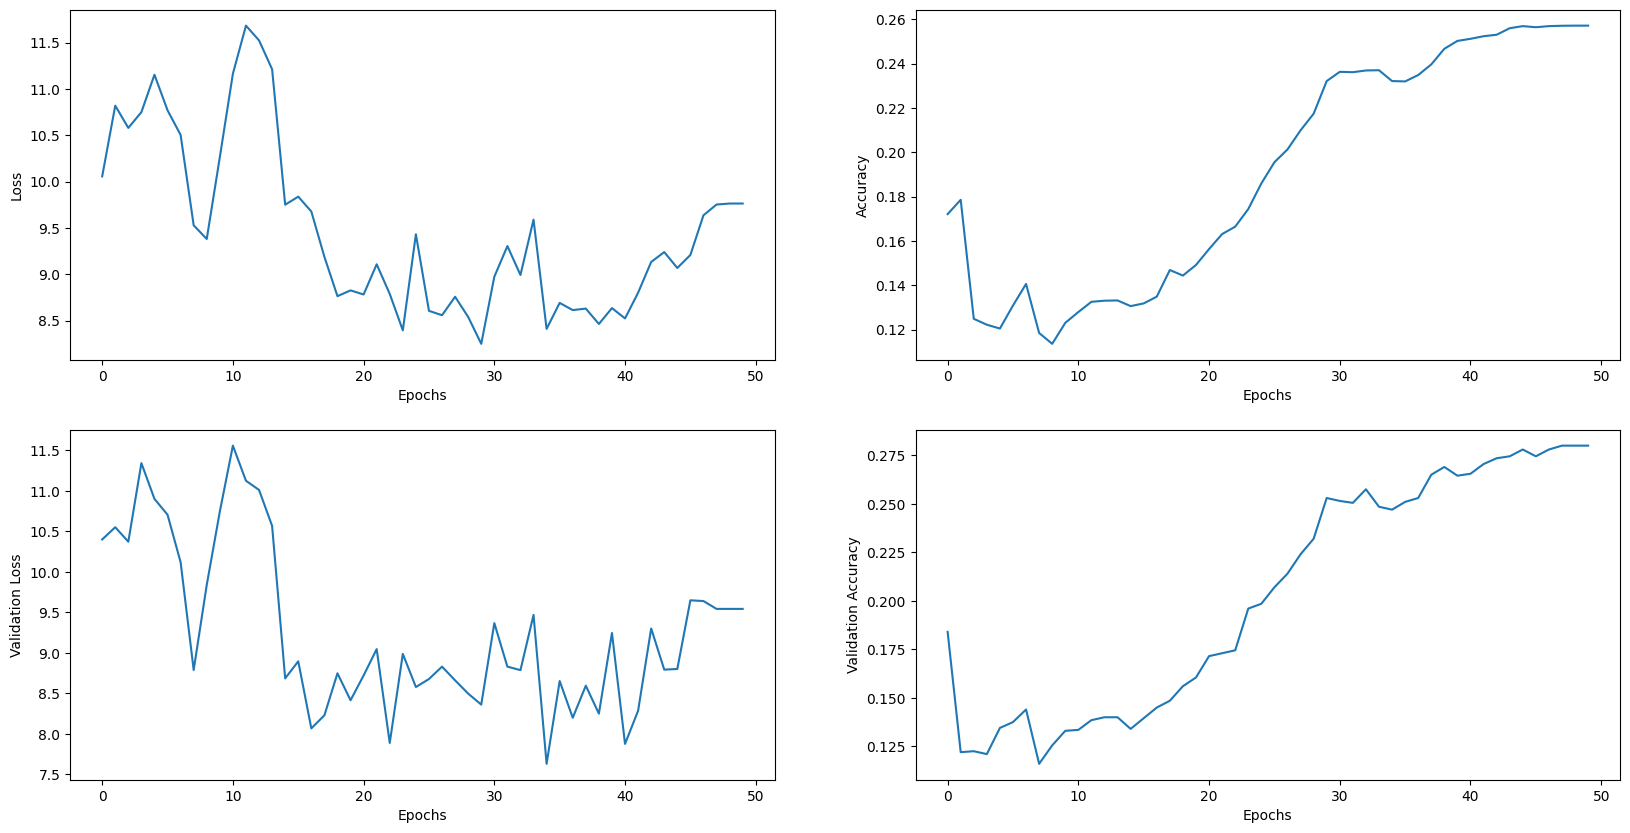

In [46]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(hist.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2, 2, 2)
plt.plot(hist.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.subplot(2, 2, 3)
plt.plot(hist.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.subplot(2, 2, 4)
plt.plot(hist.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

In [47]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {results[0]} | Test acc: {results[1]}")

Test loss: 9.72608470916748 | Test acc: 0.25690001249313354


In [48]:
preds = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test_copy, preds)
pre_macro = precision_score(y_test_copy, preds, average="macro")
pre_micro = precision_score(y_test_copy, preds, average="micro")
recall_macro = recall_score(y_test_copy, preds, average="macro")
recall_micro = recall_score(y_test_copy, preds, average="micro")
f1_macro = f1_score(y_test_copy, preds, average="macro")
f1_micro = f1_score(y_test_copy, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

313/313 [==============================] - 0s 657us/step
Accuracy: 25.69%
Macro-averaged Precision: 16.76%
Macro-averaged Recall: 25.46%
Macro-averaged F1 Score: 18.56%


c:\Users\eavil\anaconda3\envs\patrones\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


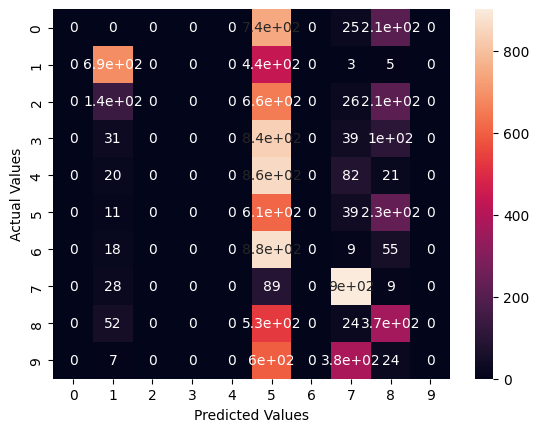

In [49]:
cm = confusion_matrix(y_test_copy, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

## 2.11. Multi Layer Perceptron

In [50]:
tf.random.set_seed(42)
hidden1 = tf.keras.layers.Dense(units=512, activation="relu", input_shape=[784])
drop1 = tf.keras.layers.Dropout(0.2)
hidden2 = tf.keras.layers.Dense(units=512, activation="relu")
drop2 = tf.keras.layers.Dropout(0.2)
out = tf.keras.layers.Dense(units=10, activation="softmax")
model = tf.keras.Sequential([
    hidden1,
    drop1,
    hidden2,
    drop2,
    out
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=50, verbose=False)

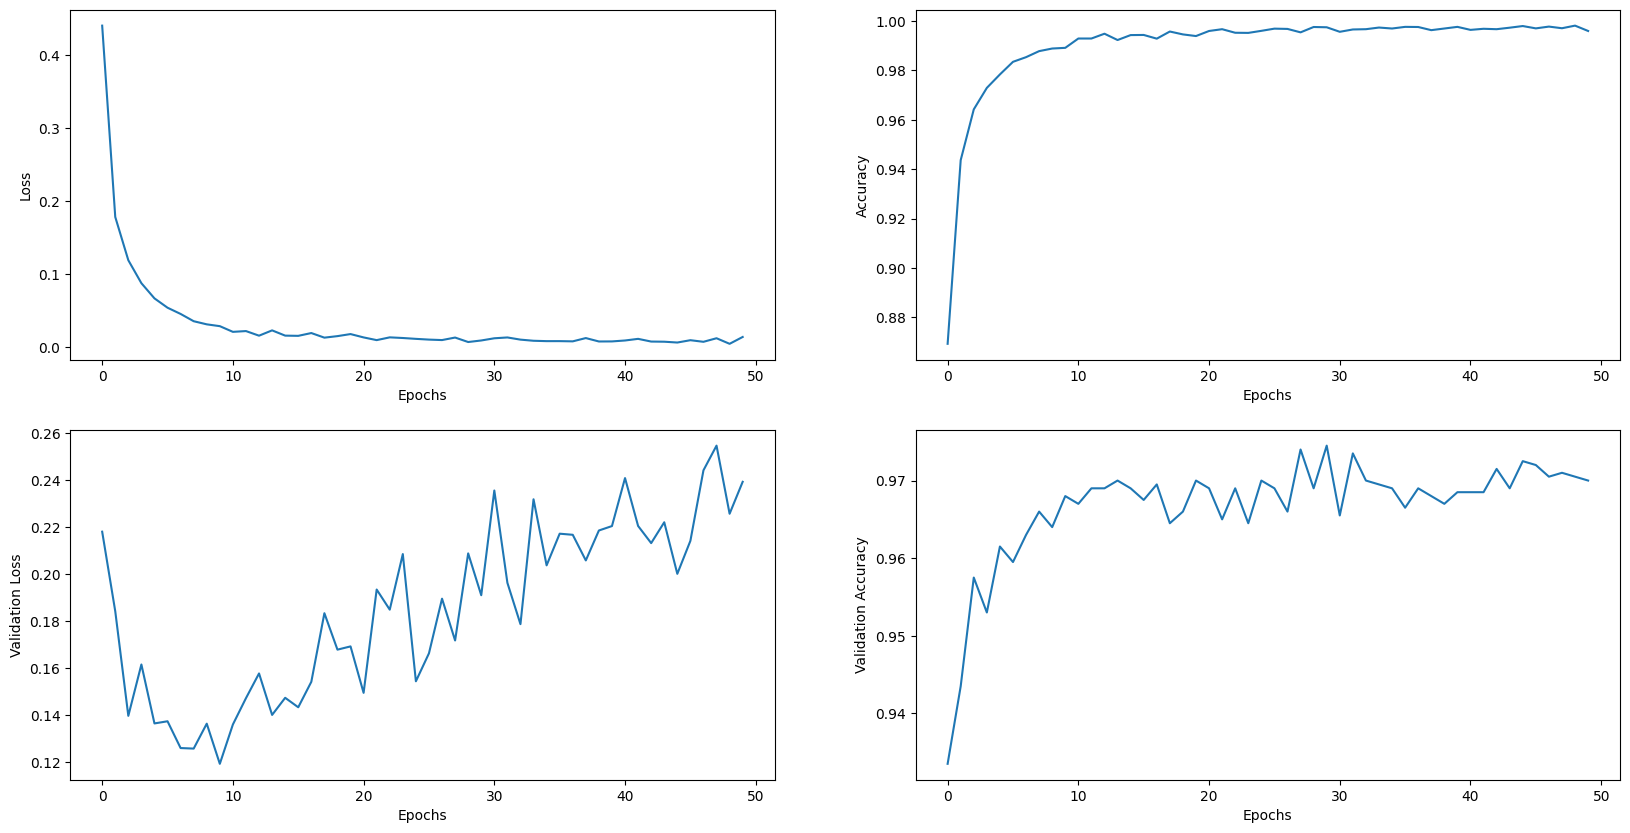

In [51]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(hist.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(2, 2, 2)
plt.plot(hist.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.subplot(2, 2, 3)
plt.plot(hist.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.subplot(2, 2, 4)
plt.plot(hist.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

In [52]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {results[0]} | Test acc: {results[1]}")

Test loss: 0.18919846415519714 | Test acc: 0.9718000292778015


In [53]:
preds = np.argmax(model.predict(X_test), axis=1)
acc = accuracy_score(y_test_copy, preds)
pre_macro = precision_score(y_test_copy, preds, average="macro")
pre_micro = precision_score(y_test_copy, preds, average="micro")
recall_macro = recall_score(y_test_copy, preds, average="macro")
recall_micro = recall_score(y_test_copy, preds, average="micro")
f1_macro = f1_score(y_test_copy, preds, average="macro")
f1_micro = f1_score(y_test_copy, preds, average="micro")
print(f"Accuracy: {acc*100:.2f}%")
print(f"Macro-averaged Precision: {pre_macro*100:.2f}%")
print(f"Macro-averaged Recall: {recall_macro*100:.2f}%")
print(f"Macro-averaged F1 Score: {f1_macro*100:.2f}%")

313/313 [==============================] - 0s 640us/step
Accuracy: 97.18%
Macro-averaged Precision: 97.23%
Macro-averaged Recall: 97.12%
Macro-averaged F1 Score: 97.16%


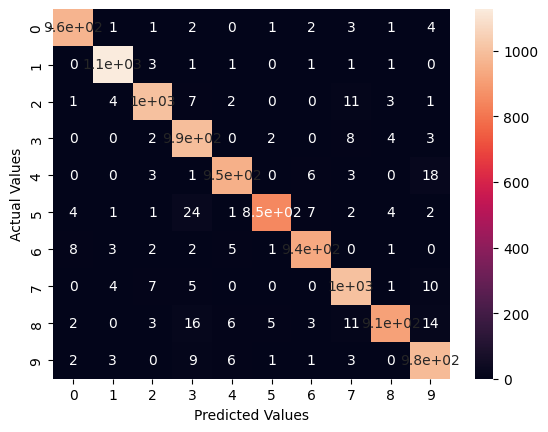

In [54]:
cm = confusion_matrix(y_test_copy, preds)
fig = plt.figure()
sns.heatmap(cm, annot=True)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

# 3. Discusiones

Se implementaron diversos modelos para poder identificar dígitos escritos a mano a partir del conjunto de datos MNIST. Estos modelos fueron: RandomForest (RF), Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Logistic Regression (LR), Decision Tree (DT), AdaBoost Classifier (ADA), Bagging Classifier (BAG), Gradient Boosting (GRA), Histogram Gradient Boosting (HIS), Simple Perceptron (SP) y Multi Layer Perceptron (MLP). Cada uno de estos modelos tiene sus propias fortalezas, lo que los puede hacer adecuados para diferentes tipos de tareas de clasificación.

Hablemos primero de los modelos que no contienen perceptrones. De entre estos, los mejores resultados fueron SVM y HIS, con un accuracy del 97.00% y 96.85% respectivamente. Un modelo de SVM busca el hiperplano de separación óptimo, lo que lo hace muy eficiente para la clasificación de imágenes [3]. Por otra parte, HIS es una versión mejorada de GRA que utiliza histogramas para reducir el número de divisiones a considerar, mejorando su precisión y velocidad [4].

Tomando el rendimiento de HIS como excusa, se discutirá el rendimiento de los métodos de ensamble evaluados en este trabajo. El de mejor rendimiento después de HIS fue RF con 95.92%. RF es un modelo que entrena un número de DT con varias sub muestras del dataset y usa la media para mejorar la precisión predictiva y controlar el over-fitting [5].  Por lo mismo que utiliza una serie de clasificadores suaves, es que cuenta con un mejor rendimiento que modelos como KNN, LR y DT.

El modelo GRA obtuvo también un muy buen rendimiento, con un accuracy del 94.01%. GRA es un método de ensemble que fabrica modelos secuencialmente, corrigiendo los errores del modelo anterior, mejorando su precisión [4]. No obstante, no fue tan efectivo como HIS, lo que era de esperarse, pues como se mencionó previamente, HIS es una versión superior de GRA.

El modelo BAG tuvo un accuracy del 92.21%. Bagging Classifier es un método de ensemble que combina las predicciones de varios modelos [6]. Es posible que su rendimiento ligeramente inferior al resto de modelos es que no cuenta con un método de reducción de errores como tal entre predicciones.

El modelo con el peor rendimiento dentro de los modelos de ensamble fue ADA, ya que tuvo un accuracy del 75.49%. AdaBoost es un método de ensemble que asigna pesos a las instancias en el conjunto de datos en función de qué tan difíciles son de clasificar. Sin embargo, AdaBoost sufre con datos ruidosos y valores atípicos, lo que puede explicar su peor desempeño [7]. Esto se nota sobre todo cuando nos damos cuenta que los números con los que más sufre este modelo son los pares de números 4-9, 3-5, y 7-9, los cuales son muy similares entre sí para algunas caligrafías.

En cuanto a los modelos de perceptrones, estos tuvieron que ser provistos de data pre-procesada, pues los modelos de redes neuronales se benefician de contar con datos normalizados y necesitan de tener etiquetas como categorías. Es notable la diferencia en rendimiento entre un modelo con un perceptron y un modelo con multicapas de perceptrones, pues el modelo SP contaba con una precisión del 25.69% y el modelo MLP contaba con el mejor rendimiento de entre todos los modelos con una precisión de 97.18%.

El pobre rendimiento del SP puede atribuirse a su simplicidad. El SP es un modelo lineal y puede tener dificultades para manejar datos que no son linealmente separables, como es el caso de las imágenes de dígitos escritos a mano [8]. Mientras que el gran rendimiento de MLP se le puede atribuir a la capacidad de los perceptrones en multicapas de modelar relaciones no lineales y su flexibilidad para adaptarse a diferentes estructuras de datos [9]. Por otro lado, para evitar el sobreajuste, se utilizaron capas de Droput, pues es una técnica que elimina aleatoriamente unidades en la red neuronal durante el entrenamienot para así lograr una mejor generalización [10].

Una de las principales ventajas observadas en este challenge sobre las redes neuronales es su capacidad de aprender y mejorar a lo largo del tiempo, gracias a que es capaz de adaptarse a cambios [9]. Por otro lado, son modelos robustos al fallo, ya que el fallo de alguna de las neuronas no es un impedimento para que la red deje de funcionar [11]. No obstante, las principales desventajas de este tipo de modelos es que requieren de una cantidad de datos muy grande, por lo que en ciertas aplicaciones se convierte impráctico pues conseguir una gran cantidad de datos no siempre es viable [12]; también tienden al overfitting si se entrena por mucho tiempo al modelo [13]; requieren de una gran cantidad de tiempo y recursos computacionales para el entrenamiento de estos modelos [12]; y es relativamente difícil elegir la arquitectura de la red neuronal a emplear [13]. No obstante, los problemas de la poca cantidad de datos y la elección de la arquitectura se pueden solucionar con el uso de modelos pre-entrenados empleando el método conocido como Transfer Learning.

# 4. Conclusiones

- Los modelos sin el paradigma de perceptrones que obtuvieron mejores resultados fueron Support Vector Machine y Histogram Gradient Boosting. El primero por ser un algoritmo de clasificación capaz de encontrar características no lineales gracias al kernel empleado y el segundo gracias a que es un algoritmo de boosting por gradiente que utiliza histogramas para reducir el número de divisiones a considerar, mejorando su precisión y velocidad
- El mejor modelo de entre los probados es Multi Layer Perceptron, el cual es una red neuronal. Esto gracias a que las redes neuronales son altamente flexibles y son capaces de mejorar resultados en cada iteración.
- Los modelos de perceptrones de una capa no encuentran relaciones no lineales fácilmente, por lo que los hace significativamente peores en rendimiento en comparación con los modelos multicapa de perceptrones.
- Las principales ventajas de las redes neuronales se les atribuye a su capacidad de aprender de los errores y la robustez al fallo que estos tienen.
- Las principales desventajas de las redes neuronales se les atribuye a la necesidad de contar con una gran cantidad de datos, tendencia al overfitting si se entrena por mucho tiempo, requieren de gran cantidad de tiempo y recursos computacionales, y es complicado escoger la arquitectura adecuada para un problema específico.
- Una forma de solucionar la poca cantidad de datos para entrenamiento y la elección de la arquitectura de la red neuronal es mediante Transfer Learning.

# 5. Referencias

[1] J. Bobadilla, Machine Learning y Deep Learning: Usando Python, Scikit y Keras, 1. Paracuellos de Jarama, Madrid: RA-MA Editorial, 2020 (online) . https://elibro.net/es/ereader/cayetano/222698?page=44 (accessed May 31, 2023).

[2] LeCun, Y.; Cortes, C.; Burges, C.J.C. The MNIST Database of Handwritten Digits. 2012 (online). http://yann.lecun.com/exdb/mnist/ (accessed MAY 21, 2023).


[3] G. Ke et al., “LightGBM: A Highly Efficient Gradient Boosting Decision Tree,” 2017. Available: https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

[4] J. H. Friedman, “Greedy function approximation: A gradient boosting machine.,” vol. 29, no. 5, Oct. 2001, doi: https://doi.org/10.1214/aos/1013203451.

[5] IBM, "What is random forest?" [Online] Available at: https://www.ibm.com/topics/random-forest

[6] L. Breiman, “Bagging predictors”, Machine Learning, 24(2), 123-140, 1996.

[7] Y. Freund and R. E. Schapire, “A Decision-Theoretic Generalization of On-Line Learning and an Application to Boosting,” vol. 55, no. 1, pp. 119–139, Aug. 1997, doi: https://doi.org/10.1006/jcss.1997.1504.

[8] Team rédac, “Perceptron : qu’est-ce que c’est et à quoi ça sert ?,” Formation Data Science | DataScientest.com, Mar. 07, 2022. https://datascientest.com/es/perceptron-que-es-y-para-que-sirve (accessed Jun. 01, 2023).

[9] C. Bento, “Multilayer Perceptron Explained with a Real-Life Example and Python Code: Sentiment Analysis,” Medium, Sep. 21, 2021. https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141 (accessed Jun. 01, 2023).

[10] TensorFlow. "tf.keras.layers.Dropout" [Online] Available at: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

[11] UNAL, "Redes neuronales" [Online] Available at: https://disi.unal.edu.co/~lctorress/RedNeu/LiRna008.pdf

[12] IBM, "¿Qué es Deep Learning?" [Online] Available at: https://www.ibm.com/es-es/topics/deep-learning

[13] P. Madan, S. Madhavan, "An introduction to deep learning" [Online] Available at: https://developer.ibm.com/learningpaths/get-started-with-deep-learning/an-introduction-to-deep-learning/